# Recommender System Training - LightFM

In this notebook we will train recommender system in order to map users susceptible answer to a question.

In [1]:
from utils import SERIALIZED_DATA_ARTIFACT_NAMES, read_data, track_model_metrics, prepare_all_predictions
import pandas as pd
import numpy as np

/home/okteto/user_recommendation/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random_state = 42

## Pure CF model

### Get Datasets

In [3]:
# Load datasets containing all users and questions interactions
answers = read_data("answers.json")

In [4]:
# Load train test datasets
train = pd.read_csv("../"+SERIALIZED_DATA_ARTIFACT_NAMES.path_to_train_dataset)
test_cs = pd.read_csv("../"+SERIALIZED_DATA_ARTIFACT_NAMES.path_to_test_cold_start_dataset)
test_ws = pd.read_csv("../"+SERIALIZED_DATA_ARTIFACT_NAMES.path_to_test_warm_start_dataset)
eval_cs = pd.read_csv("../"+SERIALIZED_DATA_ARTIFACT_NAMES.path_to_eval_cold_start_dataset)
eval_ws = pd.read_csv("../"+SERIALIZED_DATA_ARTIFACT_NAMES.path_to_eval_warm_start_dataset)
test = pd.concat([test_cs, test_ws], ignore_index=True)
eval_ds = pd.concat([eval_cs, eval_ws], ignore_index=True)

### Create LightFM Dataset

In [5]:
from lightfm.data import Dataset

dataset = Dataset()
dataset.fit((question_id for question_id in answers.question_id.tolist()),
            (user_id for user_id in answers.user_id.tolist()))

In [6]:
num_question, num_user = dataset.interactions_shape()
print('Num question: {}, num_user {}.'.format(num_question, num_user))

Num question: 71036, num_user 45471.


### Training with equal weights

Create interactions for each dataset to train and test model

In [7]:
train_interactions, _ = dataset.build_interactions(((row["question_id"], row["user_id"])
                                                      for index, row in train.iterrows()))
test_interactions, _ = dataset.build_interactions(((row["question_id"], row["user_id"])
                                                      for index, row in test.iterrows()))
test_ws_interactions, _ = dataset.build_interactions(((row["question_id"], row["user_id"])
                                                      for index, row in test_ws.iterrows()))
test_cs_interactions, _ = dataset.build_interactions(((row["question_id"], row["user_id"])
                                                      for index, row in test_cs.iterrows()))
eval_interactions, _ = dataset.build_interactions(((row["question_id"], row["user_id"])
                                                      for index, row in eval_ds.iterrows()))

#### Train model

In [8]:
NUM_THREADS=4
NUM_EPOCHS=5
K=5

2022-07-16 15:04:07,713 :: switch_backend :: DEBUG :: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2022-07-16 15:04:07,721 :: switch_backend :: DEBUG :: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2022-07-16 15:04:07,725 :: _findfont_cached :: DEBUG :: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2022-07-16 15:04:07,726 :: _findfont_cached :: DEBUG :: findfont: score(FontEntry(fname='/home/okteto/user_recommendation/.venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-16 15:04:07,727 :: _findfont_cached :: DEBUG :: findfont: score(FontEntry(fname='/home/okteto/user_recommendation/.venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='n

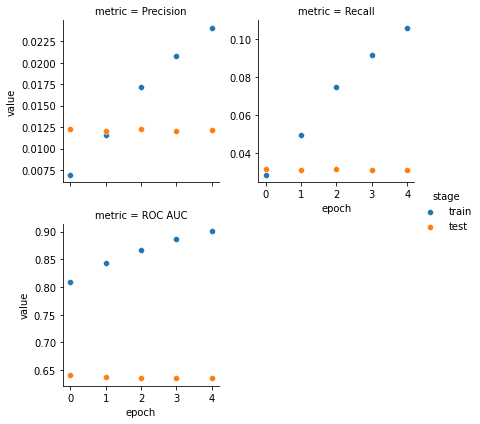

In [9]:
from lightfm import LightFM


model = LightFM(loss='warp', random_state=random_state)

output1, _ = track_model_metrics(model=model, 
                                 train_interactions=train_interactions, 
                                 test_interactions=eval_interactions, 
                                 k=K,
                                 no_epochs=NUM_EPOCHS, 
                                 no_threads=NUM_THREADS)

In [10]:
model.fit(train_interactions, verbose=True, epochs=1)

Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.28it/s]


In [11]:
# Import the evaluation routines
from lightfm.evaluation import auc_score

# Compute and print the AUC score
test_auc = auc_score(model, test_interactions, train_interactions=train_interactions, num_threads=NUM_THREADS).mean()
print('Collaborative filtering test AUC: %s' % test_auc)

test_ws_auc = auc_score(model, test_ws_interactions, train_interactions=train_interactions, num_threads=NUM_THREADS).mean()
print('Collaborative filtering test warm_start AUC: %s' % test_ws_auc)

test_cs_auc = auc_score(model, test_cs_interactions, train_interactions=train_interactions, num_threads=NUM_THREADS).mean()
print('Collaborative filtering test cold_start AUC: %s' % test_cs_auc)

Collaborative filtering test AUC: 0.6244458
Collaborative filtering test warm_start AUC: 0.6167703
Collaborative filtering test cold_start AUC: 0.6321211


### Training with weights

In [12]:
train_interactions, train_weights = dataset.build_interactions(((row["question_id"], row["user_id"], row["score"])
                                                      for index, row in train.iterrows()))
test_interactions, test_weights = dataset.build_interactions(((row["question_id"], row["user_id"], row["score"])
                                                      for index, row in test.iterrows()))
test_ws_interactions, test_ws_weights = dataset.build_interactions(((row["question_id"], row["user_id"], row["score"])
                                                      for index, row in test_ws.iterrows()))
test_cs_interactions, test_cs_weights = dataset.build_interactions(((row["question_id"], row["user_id"], row["score"])
                                                      for index, row in test_cs.iterrows()))
eval_interactions, eval_weights = dataset.build_interactions(((row["question_id"], row["user_id"], row["score"])
                                                      for index, row in eval_ds.iterrows()))

#### Train model

In [13]:
NUM_THREADS=4
NUM_EPOCHS=5
K=5

2022-07-16 15:28:00,141 :: _update_title_position :: DEBUG :: top of Axes not in the figure, so title not moved
2022-07-16 15:28:00,192 :: _update_title_position :: DEBUG :: top of Axes not in the figure, so title not moved
2022-07-16 15:28:00,226 :: _update_title_position :: DEBUG :: top of Axes not in the figure, so title not moved
2022-07-16 15:28:00,328 :: _update_title_position :: DEBUG :: top of Axes not in the figure, so title not moved
2022-07-16 15:28:00,442 :: _update_title_position :: DEBUG :: top of Axes not in the figure, so title not moved
2022-07-16 15:28:00,535 :: _update_title_position :: DEBUG :: top of Axes not in the figure, so title not moved
2022-07-16 15:28:00,604 :: _update_title_position :: DEBUG :: top of Axes not in the figure, so title not moved
2022-07-16 15:28:00,638 :: _update_title_position :: DEBUG :: top of Axes not in the figure, so title not moved


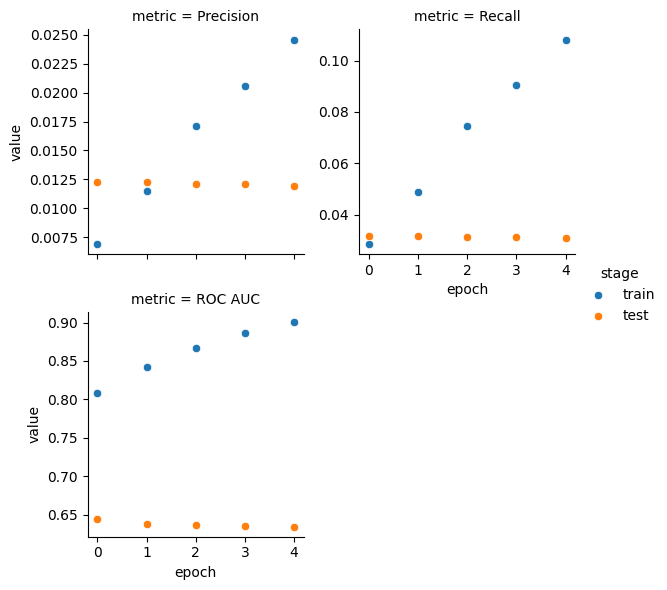

In [14]:
from lightfm import LightFM


model = LightFM(loss='warp', random_state=random_state)

output2, _ = track_model_metrics(model=model, 
                                 train_interactions=train_interactions, 
                                 test_interactions=eval_interactions, 
                                 k=K,
                                 no_epochs=NUM_EPOCHS, 
                                 no_threads=NUM_THREADS)

In [15]:
model.fit(train_interactions, sample_weight=train_weights, verbose=True, epochs=1)

Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.46it/s]


In [16]:
test_auc = auc_score(model, test_interactions, train_interactions=train_interactions, num_threads=NUM_THREADS).mean()
print('Collaborative filtering test AUC: %s' % test_auc)

test_ws_auc = auc_score(model, test_ws_interactions, train_interactions=train_interactions, num_threads=NUM_THREADS).mean()
print('Collaborative filtering test warm_start AUC: %s' % test_ws_auc)

test_cs_auc = auc_score(model, test_cs_interactions, train_interactions=train_interactions, num_threads=NUM_THREADS).mean()
print('Collaborative filtering test cold_start AUC: %s' % test_cs_auc)

Collaborative filtering test AUC: 0.6342798
Collaborative filtering test warm_start AUC: 0.6314484
Collaborative filtering test cold_start AUC: 0.6371113


## Hybrid model

In [1]:
from utils import SERIALIZED_DATA_ARTIFACT_NAMES, read_data, track_model_metrics, prepare_all_predictions
import pandas as pd
import numpy as np

/home/okteto/user_recommendation/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random_state = 42

### Get Datasets

In [3]:
# Load datasets containing all users and questions interactions
answers = read_data("answers.json")

In [9]:
# Load train test datasets
users_features = pd.read_csv("../data/features/users_features.csv")
questions_features = pd.read_csv("../data/features/question_features.csv")
train = pd.read_csv("../"+SERIALIZED_DATA_ARTIFACT_NAMES.path_to_train_dataset)
test_cs = pd.read_csv("../"+SERIALIZED_DATA_ARTIFACT_NAMES.path_to_test_cold_start_dataset)
test_ws = pd.read_csv("../"+SERIALIZED_DATA_ARTIFACT_NAMES.path_to_test_warm_start_dataset)
eval_cs = pd.read_csv("../"+SERIALIZED_DATA_ARTIFACT_NAMES.path_to_eval_cold_start_dataset)
eval_ws = pd.read_csv("../"+SERIALIZED_DATA_ARTIFACT_NAMES.path_to_eval_warm_start_dataset)
test = pd.concat([test_cs, test_ws], ignore_index=True)
eval_ds = pd.concat([eval_cs, eval_ws], ignore_index=True)

/tmp/ipykernel_48713/1836969902.py:2: DtypeWarning: Columns (5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  users_features = pd.read_csv("../data/features/users_features.csv")


In [20]:
tags_column = ["tag1", "tag2", "tag3", "tag4", "tag5"]
num_col = ['reputation','up_votes','down_votes','views']

In [23]:
pd.unique(users_features[tags_column+num_col].values.ravel('K'))

array([nan, 'fdsoi', 'ꮢսᏼꭹ', ..., 5631, 7167, 14591], dtype=object)

### Create LightFM Dataset

In [6]:
from lightfm.data import Dataset

dataset = Dataset()
dataset.fit((question_id for question_id in answers.question_id.tolist()),
            (user_id for user_id in answers.user_id.tolist()))

In [7]:
num_question, num_user = dataset.interactions_shape()
print('Num question: {}, num_user {}.'.format(num_question, num_user))

Num question: 71036, num_user 45471.


Add information about users and questions

In [8]:

dataset.fit_partial(users=(question_id for question_id in questions_features.question_id.tolist()),
                    user_features=(list(set(questions_features[tags_column].values.flatten()))),
                    items=(users_id for users_id in users_features.id.tolist()),
                    item_features=(list(set(users_features[tags_column+num_col].values.flatten()))))

### Build interactions, user features and question features

In [9]:
train_interactions, train_weights = dataset.build_interactions(((row["question_id"], row["user_id"], row["score"])
                                                      for index, row in train.iterrows()))
test_interactions, test_weights = dataset.build_interactions(((row["question_id"], row["user_id"], row["score"])
                                                      for index, row in test.iterrows()))
test_ws_interactions, test_ws_weights = dataset.build_interactions(((row["question_id"], row["user_id"], row["score"])
                                                      for index, row in test_ws.iterrows()))
test_cs_interactions, test_cs_weights = dataset.build_interactions(((row["question_id"], row["user_id"], row["score"])
                                                      for index, row in test_cs.iterrows()))
eval_interactions, eval_weights = dataset.build_interactions(((row["question_id"], row["user_id"], row["score"])
                                                      for index, row in eval_ds.iterrows()))

In [10]:
from typing import Optional, TypeVar

COOMatrix = TypeVar("COOMatrix")

def get_questions_features(data: pd.DataFrame, dataset: Dataset, tags_column: list[str]) -> COOMatrix:
    """Build questions features from lightfm dataset and dataframe

    Args:
        data: interactions to build
        dataset: light fm dataset

    Returns:
        COOMatrix: questions features matrix
    """
    columns = ["question_id"] + tags_column
    return dataset.build_user_features(((row[0], list(row[1:])) for row in data[columns].itertuples(index=False, name=None)))  # type: ignore


def get_users_features(data: pd.DataFrame, dataset: Dataset, tags_column: list[str]) -> COOMatrix:
    """Build users features from lightfm dataset and dataframe

    Args:
        data: interactions to build
        dataset: light fm dataset

    Returns:
        COOMatrix: users features matrix
    """
    columns = ["id"] + tags_column + num_col
    return dataset.build_item_features(((row[0], list(row[1:])) for row in data[columns].itertuples(index=False, name=None)))  # type: ignore

In [11]:
users_features_matrix = get_users_features(  # type: ignore
            data=users_features, dataset=dataset, tags_column=tags_column+num_col
        )

In [12]:
questions_features_matrix = get_questions_features(  # type: ignore
            data=questions_features, dataset=dataset, tags_column=tags_column
        )

### Training with weights

#### Train model

In [13]:
NUM_THREADS=4
NUM_EPOCHS=3
K=5

In [14]:
from lightfm import LightFM


model = LightFM(loss='warp', random_state=random_state, no_components=24)

# output3, _ = track_model_metrics(model=model, 
#                                  train_interactions=train_interactions, 
#                                  test_interactions=eval_interactions, 
#                                  k=K,
#                                  no_epochs=NUM_EPOCHS, 
#                                  no_threads=NUM_THREADS)

In [15]:
model.fit(train_interactions, sample_weight=train_weights, verbose=True, epochs=4, item_features=users_features_matrix, user_features=questions_features_matrix)

Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


In [16]:
from lightfm.evaluation import auc_score

test_auc = auc_score(model, test_interactions, train_interactions=train_interactions, item_features=users_features_matrix, user_features=questions_features_matrix, num_threads=NUM_THREADS).mean()
print('Collaborative filtering test AUC: %s' % test_auc)

test_ws_auc = auc_score(model, test_ws_interactions, train_interactions=train_interactions, item_features=users_features_matrix, user_features=questions_features_matrix, num_threads=NUM_THREADS).mean()
print('Collaborative filtering test warm_start AUC: %s' % test_ws_auc)

test_cs_auc = auc_score(model, test_cs_interactions, train_interactions=train_interactions, item_features=users_features_matrix, user_features=questions_features_matrix, num_threads=NUM_THREADS).mean()
print('Collaborative filtering test cold_start AUC: %s' % test_cs_auc)

Collaborative filtering test AUC: 0.76434964
Collaborative filtering test warm_start AUC: 0.76366615
Collaborative filtering test cold_start AUC: 0.7650332
